

## Deep Learning Model




In [1]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

import numpy as np
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

loaded_model = keras.models.load_model("/content/drive/MyDrive/Handwritting OCR 10 epochs")

!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words

!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data
!head -20 data/words.txt

base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]


def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

batch_size = 64
padding_token = 99
image_width = 128
image_height = 32
max_len = 21

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


# Assuming build_model and preprocess_image are defined in your code
prediction_model = keras.models.Model(
    loaded_model.get_layer(name="image").input, loaded_model.get_layer(name="dense2").output
)




#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE
Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823
Maximum length:  21
Vocab 

In [2]:
import os
os.getcwd()
os.chdir("/content/drive/MyDrive/WordDetector")
os.getcwd()

'/content/drive/MyDrive/WordDetector'

## Word Detector

In [3]:
from collections import defaultdict
from dataclasses import dataclass
from typing import List

import cv2
import numpy as np
from sklearn.cluster import DBSCAN


@dataclass
class BBox:
    x: int
    y: int
    w: int
    h: int


@dataclass
class DetectorRes:
    img: np.ndarray
    bbox: BBox


def detect(img: np.ndarray,
           kernel_size: int,
           sigma: float,
           theta: float,
           min_area: int) -> List[DetectorRes]:
    """Scale space technique for word segmentation proposed by R. Manmatha.

    For details see paper http://ciir.cs.umass.edu/pubfiles/mm-27.pdf.

    Args:
        img: A grayscale uint8 image.
        kernel_size: The size of the filter kernel, must be an odd integer.
        sigma: Standard deviation of Gaussian function used for filter kernel.
        theta: Approximated width/height ratio of words, filter function is distorted by this factor.
        min_area: Ignore word candidates smaller than specified area.

    Returns:
        List of DetectorRes instances, each containing the bounding box and the word image.
    """
    assert img.ndim == 2
    assert img.dtype == np.uint8

    # apply filter kernel
    kernel = _compute_kernel(kernel_size, sigma, theta)
    img_filtered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    img_thres = 255 - cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # append components to result
    res = []
    components = cv2.findContours(img_thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < min_area:
            continue
        # append bounding box and image of word to result list
        x, y, w, h = cv2.boundingRect(c)  # bounding box as tuple (x, y, w, h)
        crop = img[y:y + h, x:x + w]
        res.append(DetectorRes(crop, BBox(x, y, w, h)))

    return res


def _compute_kernel(kernel_size: int,
                    sigma: float,
                    theta: float) -> np.ndarray:
    """Compute anisotropic filter kernel."""

    assert kernel_size % 2  # must be odd size

    # create coordinate grid
    half_size = kernel_size // 2
    xs = ys = np.linspace(-half_size, half_size, kernel_size)
    x, y = np.meshgrid(xs, ys)

    # compute sigma values in x and y direction, where theta is roughly the average x/y ratio of words
    sigma_y = sigma
    sigma_x = sigma_y * theta

    # compute terms and combine them
    exp_term = np.exp(-x ** 2 / (2 * sigma_x) - y ** 2 / (2 * sigma_y))
    x_term = (x ** 2 - sigma_x ** 2) / (2 * np.math.pi * sigma_x ** 5 * sigma_y)
    y_term = (y ** 2 - sigma_y ** 2) / (2 * np.math.pi * sigma_y ** 5 * sigma_x)
    kernel = (x_term + y_term) * exp_term

    # normalize and return kernel
    kernel = kernel / np.sum(kernel)
    return kernel


def prepare_img(img: np.ndarray,
                height: int) -> np.ndarray:
    """Convert image to grayscale image (if needed) and resize to given height."""
    assert img.ndim in (2, 3)
    assert height > 0
    assert img.dtype == np.uint8
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def _cluster_lines(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    # compute matrix containing Jaccard distances (which is a proper metric)
    num_bboxes = len(detections)
    dist_mat = np.ones((num_bboxes, num_bboxes))
    for i in range(num_bboxes):
        for j in range(i, num_bboxes):
            a = detections[i].bbox
            b = detections[j].bbox
            if a.y > b.y + b.h or b.y > a.y + a.h:
                continue
            intersection = min(a.y + a.h, b.y + b.h) - max(a.y, b.y)
            union = a.h + b.h - intersection
            iou = np.clip(intersection / union if union > 0 else 0, 0, 1)
            dist_mat[i, j] = dist_mat[j, i] = 1 - iou  # Jaccard distance is defined as 1-iou

    dbscan = DBSCAN(eps=max_dist, min_samples=min_words_per_line, metric='precomputed').fit(dist_mat)

    clustered = defaultdict(list)
    for i, cluster_id in enumerate(dbscan.labels_):
        if cluster_id == -1:
            continue
        clustered[cluster_id].append(detections[i])

    res = sorted(clustered.values(), key=lambda line: [det.bbox.y + det.bbox.h / 2 for det in line])
    return res


def sort_multiline(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    """Cluster detections into lines, then sort the lines according to x-coordinates of word centers.

    Args:
        detections: List of detections.
        max_dist: Maximum Jaccard distance (0..1) between two y-projected words to be considered as neighbors.
        min_words_per_line: If a line contains less words than specified, it is ignored.

    Returns:
        List of lines, each line itself a list of detections.
    """
    lines = _cluster_lines(detections, max_dist, min_words_per_line)
    res = []
    for line in lines:
        res += sort_line(line)
    return res


def sort_line(detections: List[DetectorRes]) -> List[List[DetectorRes]]:
    """Sort the list of detections according to x-coordinates of word centers."""
    return [sorted(detections, key=lambda det: det.bbox.x + det.bbox.w / 2)]


Processing file /content/drive/MyDrive/WordDetector/data/line/1.png


<ipython-input-4-3d46eb02478b>:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('rainbow', num_colors)


0 to 95 ---- 5 to 41
File written successfully: /content/drive/MyDrive/WordDetector/img_names_sequence.txt
117 to 230 ---- 15 to 38
File written successfully: /content/drive/MyDrive/WordDetector/img_names_sequence.txt
248 to 307 ---- 10 to 33
File written successfully: /content/drive/MyDrive/WordDetector/img_names_sequence.txt
331 to 384 ---- 12 to 36
File written successfully: /content/drive/MyDrive/WordDetector/img_names_sequence.txt
408 to 472 ---- 3 to 35
File written successfully: /content/drive/MyDrive/WordDetector/img_names_sequence.txt
491 to 527 ---- 18 to 30
File written successfully: /content/drive/MyDrive/WordDetector/img_names_sequence.txt
540 to 683 ---- 3 to 41
File written successfully: /content/drive/MyDrive/WordDetector/img_names_sequence.txt
709 to 856 ---- 14 to 50
File written successfully: /content/drive/MyDrive/WordDetector/img_names_sequence.txt


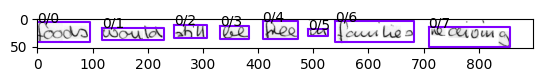

Lines  None


In [4]:
import argparse
from typing import List
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# from word_detector import detect, prepare_img, sort_multiline

# Manually set the values or use default values
parsed = argparse.Namespace(
    # data=["/content/drive/MyDrive/WordDetector/data/page/r06-137.png"],
    data = ["/content/drive/MyDrive/WordDetector/data/line/1.png"],
    kernel_size=25,
    sigma=11,
    theta=7,
    min_area=100,
    img_height=50
)

def get_img_files(data_dir: Path) -> List[Path]:
    """Return all image files contained in a folder."""
    res = []
    for ext in ['*.png', '*.jpg', '*.bmp']:
        res += Path(data_dir).glob(ext)
    return res

def save_image_names_to_text_files():
    # for fn_img in get_img_files(parsed.data):
    for fn_img in parsed.data:
        print(f'Processing file {fn_img}')

        # load image and process it
        img = prepare_img(cv2.imread(str(fn_img)), parsed.img_height)
        detections = detect(img,
                            kernel_size=parsed.kernel_size,
                            sigma=parsed.sigma,
                            theta=parsed.theta,
                            min_area=parsed.min_area)

        # sort detections: cluster into lines, then sort each line
        lines = sort_multiline(detections)

        list_img_names_serial = []
        # plot results
        plt.imshow(img, cmap='gray')
        num_colors = 7
        colors = plt.cm.get_cmap('rainbow', num_colors)
        for line_idx, line in enumerate(lines):
            for word_idx, det in enumerate(line):
                xs = [det.bbox.x, det.bbox.x, det.bbox.x + det.bbox.w, det.bbox.x + det.bbox.w, det.bbox.x]
                ys = [det.bbox.y, det.bbox.y + det.bbox.h, det.bbox.y + det.bbox.h, det.bbox.y, det.bbox.y]
                plt.plot(xs, ys, c=colors(line_idx % num_colors))
                plt.text(det.bbox.x, det.bbox.y, f'{line_idx}/{word_idx}')
                # print(det.bbox.x, det.bbox.y, det.bbox.w, det.bbox.h)
                print(det.bbox.x,"to",det.bbox.x + det.bbox.w,"----", det.bbox.y,"to",det.bbox.y + det.bbox.h)

                try:
                  crop_img = img[det.bbox.y:det.bbox.y + det.bbox.h, det.bbox.x:det.bbox.x + det.bbox.w]
                  cv2.imwrite(f"line{line_idx}word{word_idx}.jpg", crop_img)
                  full_img_path = f"line{line_idx}word{word_idx}.jpg"
                  list_img_names_serial.append(full_img_path)

                  list_img_names_serial_set = set(list_img_names_serial)

                  output_path = "/content/drive/MyDrive/WordDetector/img_names_sequence.txt"  # Change the path accordingly
                  with open(output_path, "w") as textfile:
                      for element in list_img_names_serial:
                          textfile.write(element + "\n")

                  # Print the path for confirmation
                  print(f"File written successfully: {output_path}")
                except Exception as e:
                  print("exception",e)
                  if crop_img.shape[0] <= img.shape[0] or crop_img.shape[1] >= img.shape[1]:
                      print(f"Error: Crop dimensions exceed original image dimensions for line {line_idx}, word {word_idx}")
                      print(crop_img.shape[0] , img.shape[0], crop_img.shape[1] , img.shape[1])

                  print("",end="")
        plt.show()
    # return list_img_names_serial_set

print("Lines ",save_image_names_to_text_files())

In [5]:
os.getcwd()

'/content/drive/MyDrive/WordDetector'

In [6]:
def predict_for_new_image(path):
  # Load and preprocess the new image
  # new_image_path = "/content/of.png"
  new_image_path = path


  new_image = preprocess_image(new_image_path)


  # Expand dimensions to match the model's expected input shape
  new_image = np.expand_dims(new_image, axis=0)

  # Get predictions
  preds = prediction_model.predict(new_image)

  # Decode the predictions
  decoded_text = decode_batch_predictions(preds)[0]

  # Display the results
  print("Predicted Text:", decoded_text.strip("[UNK]"))
  return decoded_text

In [ ]:
predict_for_new_image("/content/of.png")

1/1 [==============================] - 0s 36ms/step
Predicted Text: of


In [7]:
os.chdir("/content/drive/MyDrive/WordDetector")
os.listdir()

['IAM_Words.zip.1',
 'IAM_Words.zip',
 'IAM_Words.zip.2',
 'LICENSE.md',
 'requirements.txt',
 'README.md',
 '.gitignore',
 'setup.py',
 'doc',
 'tests',
 'data',
 'examples',
 'word_detector.egg-info',
 'word_detector',
 '.git',
 'build',
 'usage.py',
 '.ipynb_checkpoints',
 'line0word0.jpg',
 'line0word1.jpg',
 'line0word5.jpg',
 'line0word3.jpg',
 'line0word2.jpg',
 'line0word6.jpg',
 'img_names_sequence.txt',
 'line0word4.jpg',
 'IAM_Words',
 'main_draft1.ipynb',
 'line0word7.jpg']

In [8]:
predicted_line = []
for file in os.listdir():
  if file.split('.')[-1] in ['jpeg','png','jpg']:
    print(file)
    predicted_line.append(predict_for_new_image(file))

' '.join(predicted_line)

line0word0.jpg
1/1 [==============================] - 6s 6s/step
Predicted Text: foods
line0word1.jpg
1/1 [==============================] - 0s 91ms/step
Predicted Text: woud
line0word5.jpg
1/1 [==============================] - 0s 141ms/step
Predicted Text: un
line0word3.jpg
1/1 [==============================] - 0s 146ms/step
Predicted Text: be
line0word2.jpg
1/1 [==============================] - 0s 84ms/step
Predicted Text: still
line0word6.jpg
1/1 [==============================] - 0s 119ms/step
Predicted Text: fomiles
line0word4.jpg
1/1 [==============================] - 0s 95ms/step
Predicted Text: hee
line0word7.jpg
1/1 [==============================] - 0s 176ms/step
Predicted Text: reaong


'foods woud un be still fomiles hee reaong'